# Product Recommendation

In [1]:
import numpy as np
import pandas as pd
from customized import preprocess
from customized import metrics
from customized import end2end_recommendation
from striatum import MAB
from striatum.storage.action import Action
from neural_exploration import neuralucb_main

### with class weights

[Autoencode streamer-product features]
[Test] change Double to Float
Step [2/2], Reconstructed Loss: 0.0213
product feature: (200, 32)
streamer feature: (200, 23)
small streamer-product: (200, 55)
total: 200000, pos: 6652, neg: 193348
Weight for class 0: 0.52
Weight for class 1: 15.03


  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (1000 of 1000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


Recommend Ratio: 93.50 %
Accuracy: 11.90 %
tp: 56
tn: 63
fp: 879
fn: 2
Precision: 5.99 %
Recall: 96.55 %
Correct: 119
Regret: 87.9 %
Early Stop times: 27


100% (1000 of 1000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


Recommend Ratio: 27.70 %
Accuracy: 72.20 %
tp: 20
tn: 702
fp: 257
fn: 21
Precision: 7.22 %
Recall: 48.78 %
Correct: 722
Regret: 25.7 %
Early Stop times: 18


  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (1000 of 1000) |####################| Elapsed Time: 0:00:16 Time:  0:00:16


Recommend Ratio: 100.00 %
Accuracy: 2.00 %
tp: 20
tn: 0
fp: 980
fn: 0
Precision: 2.00 %
Recall: 100.00 %
Correct: 20
Regret: 98.0 %
Early Stop times: 27


100% (1000 of 1000) |####################| Elapsed Time: 0:00:19 Time:  0:00:19


Recommend Ratio: 100.00 %
Accuracy: 2.40 %
tp: 24
tn: 0
fp: 976
fn: 0
Precision: 2.40 %
Recall: 100.00 %
Correct: 24
Regret: 97.6 %
Early Stop times: 13
aenn's regret: 87.9 %
vaenn's regret: 25.7 %
aebnn's regret: 98.0 %
vaebnn's regret: 97.6 %


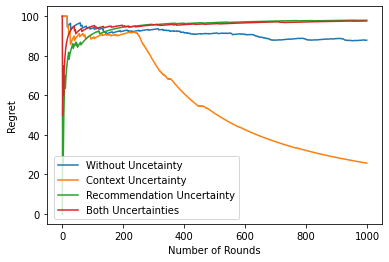

aenn's coverage: 0.8719 %
vaenn's coverage: 0.6164 %
aebnn's coverage: 0.3007 %
vaebnn's coverage: 0.3608 %


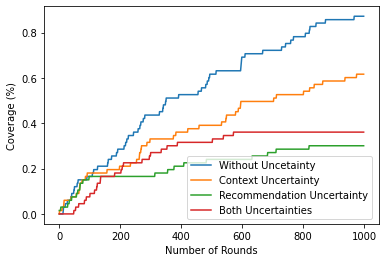

aenn's diversity: 58.5 %
vaenn's diversity: 85.0 %
aebnn's diversity: 73.5 %
vaebnn's diversity: 98.5 %


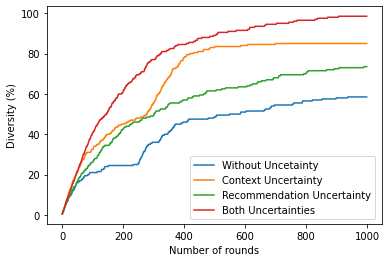

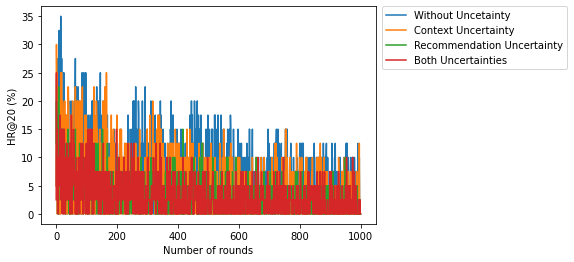

aenn's hit ratio: 40.7396 %
vaenn's hit ratio: 28.623 %
aebnn's hit ratio: 19.8136 %
vaebnn's hit ratio: 19.2423 %


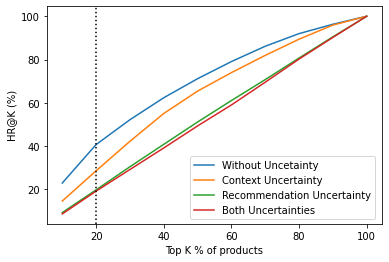

In [2]:
experiments = ['aenn', 'vaenn', 'aebnn', 'vaebnn']
mylabels = ['Without Uncetainty', 'Context Uncertainty', 'Recommendation Uncertainty', 'Both Uncertainties']
fig_name = 'end2end_lers_structure_sm_weights'

regrets_structure_w, hr_structure_w, coverage_structure_w, diversity_structure_w, \
small_reward_pivot, cust_id, reward_cust_id, reward_prod_id, highest_idxs = \
    end2end_recommendation.main(experiments, mylabels, fig_name, \
                                1000, 200, z_dim=20, weight_eps=1, class_weight = True)

In [25]:
# res = []
# for i, idx in enumerate(highest_idxs['aenn']): # aenn: 58=56(tp)+2(fn), vaenn: 41=20+21, aebnn: 20=20+0, vaebnn: 24=24+0
#     res.append(small_reward_pivot.iloc[i, idx])
# sum(res)

# MAB

In [3]:
import importlib
importlib.reload(MAB)
importlib.reload(neuralucb_main)
def main(num, full_context, context_id, rewards, reward_prod_id, lers_regret, lers_hr, lers_coverage, lers_diversity): # 2602人, 815dim
    
    actions = []
    for prod_id in reward_prod_id:
        action = Action(int(prod_id))
        actions.append(action)
    user_features = pd.DataFrame(np.array(full_context), index=context_id)
    small_rewards_df = pd.melt(rewards, ignore_index=False, var_name='商品id', value_name='reward')\
                    .loc[context_id].reset_index()
    print(f"user features: {user_features.shape}, reward targets: {rewards.shape}")
    
    experiment_bandit = ['aenn','vaenn','aebnn','vaebnn','UCB1', 'LinUCB', 'Exp3', 'NeuralUCB','random']
    mab_bandit = ['random', 'UCB1', 'LinUCB', 'Exp3']
    predict_id = {}
    rec_id = {}
    regret = {}
    hr = {}
    topk = {}
    coverage_dict = {} 
    diversity_dict = {}
    mylabels = ['LERS (Without Uncertainty)','LERS (Context Uncertainty)','LERS (Recommendation Uncertainty)', 'LERS (Both Uncertainties)',\
               'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB', 'Random']

    for bandit in experiment_bandit:   
        print("-----")
        print(bandit)
        if bandit in mab_bandit:      
            policy = MAB.policy_generation(bandit, actions)
            seq_error, rec_id[bandit], predict_id[bandit] = MAB.policy_evaluation(policy, bandit, num, user_features, rewards, actions, len(actions))
            regret[bandit] = MAB.regret_calculation(seq_error)
            if bandit != 'random':
                hr[bandit], k_list, topk[bandit] = metrics.cal_hit_ratio_mab(num, small_rewards_df, predict_id[bandit], min_val=10, max_val=110, step=10)
            # coverage
            coverage_dict[bandit] = MAB.cal_coverage_non_repeat(small_rewards_df, rewards, rec_id[bandit])
            # diversity
            diversity_dict[bandit] = metrics.cal_diversity(len(actions), rec_id[bandit])

        elif bandit == 'NeuralUCB':
            neuralUCB_regret, neuralUCB_reward_df, predict_id[bandit] = neuralucb_main.myNeuralUCB(user_features, rewards, p=0.2, hidden_size=32, epochs=10, use_cuda=False, seed=np.random.seed(2022))
            regret['NeuralUCB'] = neuralUCB_regret
            hr[bandit], _, topk[bandit]  = metrics.cal_hit_ratio_neuralucb(num, small_rewards_df, predict_id[bandit], min_val=10, max_val=110, step=10)
            neuralUCB_cover_miss = neuralucb_main.coverage(neuralUCB_reward_df)
            coverage_dict['NeuralUCB'] = neuralUCB_cover_miss['cover']
            # diversity
            neuralucb_rec_id = [element[0] for element in predict_id[bandit]]
            diversity_dict['NeuralUCB'] = metrics.cal_diversity(len(actions), neuralucb_rec_id)
        else:
            regret[bandit] = lers_regret[bandit]
            hr[bandit] = lers_hr[bandit]
            coverage_dict[bandit] = lers_coverage[bandit]
            diversity_dict[bandit] = lers_diversity[bandit]        
    
        
    # plot regret
    metrics.plot_regret(regret, mylabels, 'end2end_all_sm', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    # plot hit ratio
    metrics.plot_hit_ratio(hr, k_list, mylabels, 'end2end_all_sm', bbox_to_anchor=(1.02, 1), loc=2)
    # plot coverage     
    metrics.plot_coverage(coverage_dict, mylabels, 'end2end_all_sm', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    # plot diversity     
    metrics.plot_diversity(diversity_dict, mylabels, 'end2end_all_sm', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    
    return regret, hr, coverage_dict, diversity_dict, predict_id

## blurry_context

user features: (1000, 20), reward targets: (1000, 200)
-----
aenn
-----
vaenn
-----
aebnn
-----
vaebnn
-----
UCB1
Correct 29
-----
LinUCB
Correct 74
-----
Exp3
Correct 33
-----
NeuralUCB


100% (1000 of 1000) |####################| Elapsed Time: 0:04:23 Time:  0:04:23


-----
random
Correct 31
aenn's regret: 87.9 %
vaenn's regret: 25.7 %
aebnn's regret: 98.0 %
vaebnn's regret: 97.6 %
UCB1's regret: [97.1] %
LinUCB's regret: [92.6] %
Exp3's regret: [96.7] %
NeuralUCB's regret: 96.3 %
random's regret: [96.9] %


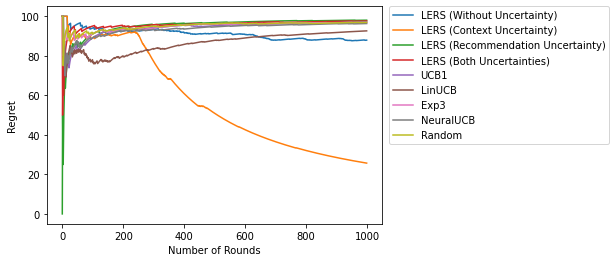

aenn's hit ratio: 40.7396 %
vaenn's hit ratio: 28.623 %
aebnn's hit ratio: 19.8136 %
vaebnn's hit ratio: 19.2423 %
UCB1's hit ratio: 21.3169 %
LinUCB's hit ratio: 22.0535 %
Exp3's hit ratio: 41.341 %
NeuralUCB's hit ratio: 21.1064 %


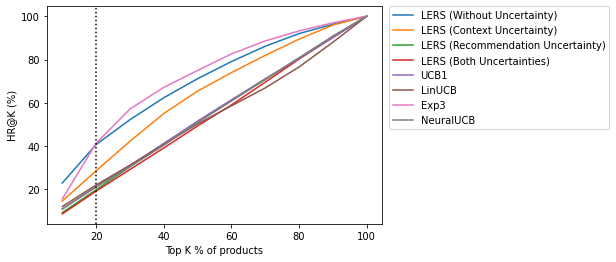

aenn's coverage: 0.8719 %
vaenn's coverage: 0.6164 %
aebnn's coverage: 0.3007 %
vaebnn's coverage: 0.3608 %
UCB1's coverage: 0.436 %
LinUCB's coverage: 1.1124 %
Exp3's coverage: 0.4961 %
NeuralUCB's coverage: 0.5562 %
random's coverage: 0.466 %


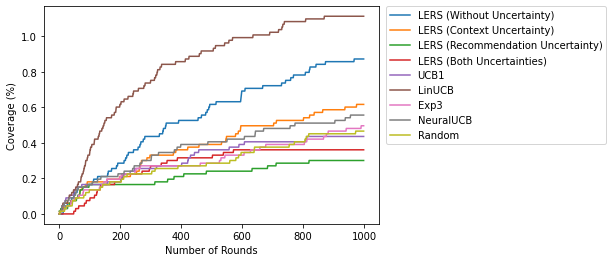

aenn's diversity: 58.5 %
vaenn's diversity: 85.0 %
aebnn's diversity: 73.5 %
vaebnn's diversity: 98.5 %
UCB1's diversity: 100.0 %
LinUCB's diversity: 100.0 %
Exp3's diversity: 99.0 %
NeuralUCB's diversity: 96.5 %
random's diversity: 98.5 %


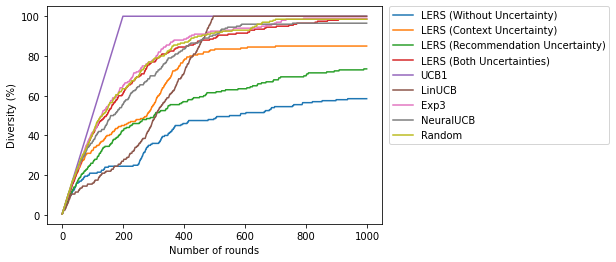

In [4]:
# import importlib
# importlib.reload(metrics)
mab_context = np.load('data/mab_context.npy') # mab_latent30
mab_context, mab_context_id, _ = preprocess.trim_cust_for_context_sort(mab_context, cust_id, reward_cust_id)
regret, hr, coverage, diversity, predict_id= \
main(len(mab_context_id), mab_context, mab_context_id, small_reward_pivot, reward_prod_id, \
     regrets_structure_w, hr_structure_w, coverage_structure_w, diversity_structure_w) 

user features: (1000, 20), reward targets: (1000, 200)
-----
aenn
-----
vaenn
-----
aebnn
-----
vaebnn
-----
UCB1
Correct 29
[Round 30] User 3589451741073236 has no favor movie.
[Round 45] User 1178133479284661 has no favor movie.
[Round 52] User 4715799948460430 has no favor movie.
[Round 68] User 722319994919010 has no favor movie.
[Round 89] User 2078866185589990 has no favor movie.
[Round 184] User 2300174690040386 has no favor movie.
[Round 231] User 2678625655743184 has no favor movie.
[Round 275] User 1181883488875137 has no favor movie.
[Round 277] User 1272785806220852 has no favor movie.
[Round 327] User 3394057894020660 has no favor movie.
[Round 393] User 2633895376895159 has no favor movie.
[Round 479] User 1047552692439193 has no favor movie.
[Round 504] User 222738922239394 has no favor movie.
[Round 533] User 2690359651282029 has no favor movie.
[Round 539] User 2736619843293530 has no favor movie.
[Round 547] User 2902923333116274 has no favor movie.
[Round 574] User 3

100% (1000 of 1000) |####################| Elapsed Time: 0:04:12 Time:  0:04:12


-----
random
Correct 31
[Round 30] User 3589451741073236 has no favor movie.
[Round 45] User 1178133479284661 has no favor movie.
[Round 52] User 4715799948460430 has no favor movie.
[Round 68] User 722319994919010 has no favor movie.
[Round 89] User 2078866185589990 has no favor movie.
[Round 184] User 2300174690040386 has no favor movie.
[Round 231] User 2678625655743184 has no favor movie.
[Round 275] User 1181883488875137 has no favor movie.
[Round 277] User 1272785806220852 has no favor movie.
[Round 327] User 3394057894020660 has no favor movie.
[Round 393] User 2633895376895159 has no favor movie.
[Round 479] User 1047552692439193 has no favor movie.
[Round 504] User 222738922239394 has no favor movie.
[Round 533] User 2690359651282029 has no favor movie.
[Round 539] User 2736619843293530 has no favor movie.
[Round 547] User 2902923333116274 has no favor movie.
[Round 574] User 3370194119669459 has no favor movie.
[Round 611] User 10217999133271051 has no favor movie.
[Round 616

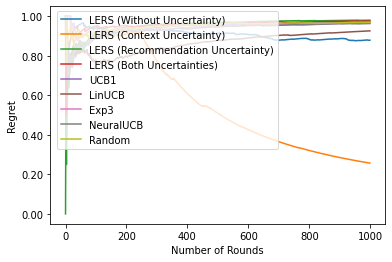

aenn's hit ratio: 40.7396 %
vaenn's hit ratio: 28.623 %
aebnn's hit ratio: 19.8136 %
vaebnn's hit ratio: 19.2423 %
UCB1's hit ratio: 21.3169 %
LinUCB's hit ratio: 22.0535 %
Exp3's hit ratio: 41.7769 %
NeuralUCB's hit ratio: 21.1064 %


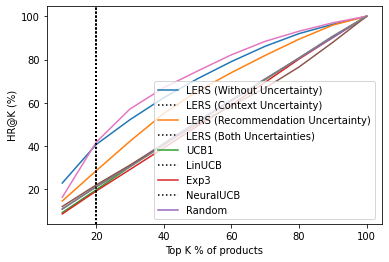

aenn's coverage: 0.8719
vaenn's coverage: 0.6164
aebnn's coverage: 0.3007
vaebnn's coverage: 0.3608
UCB1's coverage: 0.436
LinUCB's coverage: 1.1124
Exp3's coverage: 0.5111
NeuralUCB's coverage: 0.5562
random's coverage: 0.466


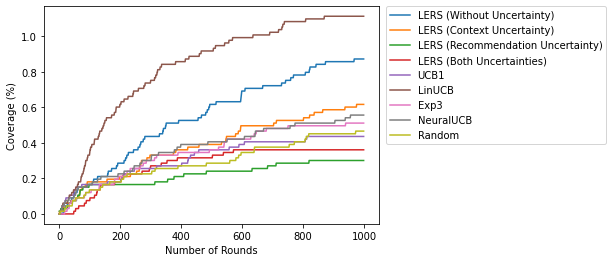

aenn's coverage: 0.8719
vaenn's coverage: 0.6164
aebnn's coverage: 0.3007
vaebnn's coverage: 0.3608
UCB1's coverage: 0.436
LinUCB's coverage: 1.1124
Exp3's coverage: 0.5111
NeuralUCB's coverage: 0.5562
random's coverage: 0.466


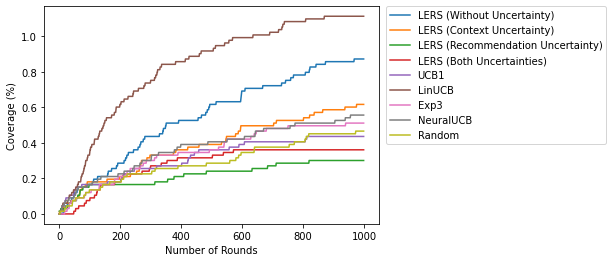

aenn's diversity: 58.5
vaenn's diversity: 85.0
aebnn's diversity: 73.5
vaebnn's diversity: 98.5
UCB1's diversity: 100.0
LinUCB's diversity: 100.0
Exp3's diversity: 100.0
NeuralUCB's diversity: 96.5
random's diversity: 98.5


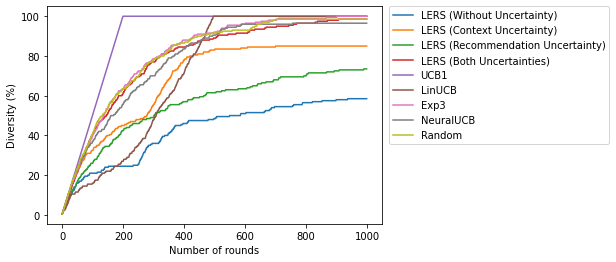

In [4]:
# import importlib
# importlib.reload(metrics)
mab_context = np.load('data/mab_context.npy') # mab_latent30
mab_context, mab_context_id, _ = preprocess.trim_cust_for_context_sort(mab_context, cust_id, reward_cust_id)
regret, hr, coverage, coverage_dict2, diversity, predict_id= \
main(len(mab_context_id), mab_context, mab_context_id, small_reward_pivot, reward_prod_id, \
     regrets_structure_w, hr_structure_w, coverage_structure_w, diversity_structure_w) 

In [ ]:
coverage['LinUCB']

In [5]:
coverage == coverage_dict2

True

## Context Comparison

### without class weights

In [8]:
experiments = ['full','static', 'temporal']
mylabels = ['Full Context','Static Context', 'Temporal Context']
fig_name = 'end2end_lers_context_sm'
regrets_context, hr_context, small_reward_pivot, cust_id, reward_cust_id, reward_prod_id, topk_context= \
end2end_recommendation.main(experiments, mylabels, fig_name, 1000, 200, z_dim=20,weight_eps=1)

### with class weights

In [ ]:
experiments = ['full','static', 'temporal']
mylabels = ['Full Context','Static Context', 'Temporal Context']
fig_name = 'end2end_lers_context_sm_weights'
_, _, _, _, _, _, _ = end2end_recommendation.main(experiments, mylabels, fig_name, 1000, 200, z_dim=20, weight_eps=1, class_weight = True)

## Temporal Context

### without class weights

In [ ]:
experiments = ['basket', 'streamer']
mylabels = ['Customer-Product Context', 'Customer-Streamer Context']
fig_name = 'end2end_lers_temporal_sm'
regrets_temporal, hr_temporal, _, _, _, _, topk_temporal= end2end_recommendation.main(experiments, mylabels, fig_name, \
                                                                                      1000, 200, z_dim=20,weight_eps=1)

### with class weights

In [ ]:
experiments = ['basket', 'streamer']
mylabels = ['Customer-Product Context', 'Customer-Streamer Context']
fig_name = 'end2end_lers_temporal_sm_weights'
_, _, _, _, _, _, _= end2end_recommendation.main(experiments, mylabels, fig_name, 1000, 200, z_dim=20, weight_eps=1, class_weight = True)

## Uncertainty Structure

### without class weights

In [ ]:
experiments = ['aenn', 'vaenn', 'aebnn', 'vaebnn']
mylabels = ['Without Uncetainty', 'Context Uncertainty', 'Recommendation Uncertainty', 'Both Uncertainties']
fig_name = 'end2end_lers_structure_sm'

regrets_structure, hr_structure, small_reward_pivot, cust_id, reward_cust_id, reward_prod_id, topk_structure = end2end_recommendation.main(experiments, mylabels, fig_name, 1000, 200, z_dim=20, weight_eps=1)